# TREND FOLLOWING
In this experiment, I would try to derive a exit method/condition for trend-following strategies. This inherently involves identifying and labelling trends

### Proposed Methods
- Directly classifying/clustering windows of returns
- Using permutation entropy (or any other entropies) in addition to clustering
- Using tr8dr's AmplitudeLabeller


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import plotly.express as px
import yfinance as yf


In [2]:
full_daterange = pd.date_range('2000-01-01', '2024-04-20', freq='D')
train_daterange = pd.date_range('2000-01-01', '2020-12-31', freq='D')
test_daterange = pd.date_range('2021-01-01', '2024-04-30', freq='D')

def clean_data(_data : pd.DataFrame, keep_volume=False, compute_target=False, look_forward=15, upper_factor=3, lower_factor=3, **kwargs):
    data = _data.copy()
    data.columns = data.columns.str.lower()

    columns = ['atr', 'returns']
    passed_columns = kwargs.get('columns', None)

    if passed_columns:
        if not isinstance(passed_columns, list):
            passed_columns = list(passed_columns)

        columns = passed_columns + columns

    data['_atr'] = ta.atr(data['high'], data['low'], data['close'], length=5)
    rolling_mean = data['_atr'].rolling(window=5).mean()
    rolling_std = data['_atr'].rolling(window=5).std()
    data.loc[:, 'atr'] = (data['_atr'] - rolling_mean) / rolling_std

    data.loc[:, '_returns'] = data['close'].pct_change(fill_method=None).fillna(0)
    rolling_mean_return = data['_returns'].rolling(window=5).mean()
    rolling_std_return = data['_returns'].rolling(window=5).std()
    data.loc[:, 'returns'] = (data['_returns'] - rolling_mean_return) / rolling_std_return

    if keep_volume:
        data.loc[:, 'volume_change'] = data['volume'].pct_change(fill_method=None)
        columns.append('volume_change')

    data = data.dropna()

    if compute_target:
        columns.append('target')
        labels = []
    
        for i in range(len(data)):
            price = data['close'].iloc[i]
            _atr = data['_atr'].iloc[i]
            upper_barrier = price + (_atr * upper_factor)
            lower_barrier = price - (_atr * lower_factor)
            
            forward_prices = data['close'].iloc[i+1:i+1+look_forward]
            
            upper_cross = forward_prices[forward_prices >= upper_barrier]
            lower_cross = forward_prices[forward_prices <= lower_barrier]
            
            if not upper_cross.empty and not lower_cross.empty:
                label = 1 if upper_cross.index[0] < lower_cross.index[0] else -1
            elif not upper_cross.empty:
                label = 1
            elif not lower_cross.empty:
                label = -1
            else:
                label = 0  # No barrier touched
            
            labels.append(label)

        data['target'] = labels


    data = data.dropna()
    data = data[data.index.isin(full_daterange)]
        

    return data[columns]




In [3]:
# DOWNLOAD YAHOO FINANCE DATA

# Define ticker symbols
es_ticker = 'EURUSD=X' # "ES=F"  # S&P 500 as a proxy for ES futures
dxy_ticker = "DX-Y.NYB"
vix_ticker = "^VIX"

df_es = yf.download(es_ticker)
df_dxy = yf.download(dxy_ticker)
df_vix = yf.download(vix_ticker)

clean_df_es = clean_data(df_es, keep_volume=False, compute_target=True, columns=['open', 'high', 'low', 'close'])
clean_df_vix = clean_data(df_vix)
clean_df_dxy = clean_data(df_dxy)

full_df = clean_df_es.join([clean_df_dxy.add_prefix('dxy_'), clean_df_vix.add_prefix('vix_')], how='inner')
train_df = full_df[full_df.index.isin(train_daterange)]
test_df = full_df[full_df.index.isin(test_daterange)]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# Functions to Visualize and Evaluate Labels

train_data = train_df[['close', 'returns']]
train_data.loc[:, 'returns'] = train_df['close'].pct_change(fill_method=None).fillna(0)
train_data = train_data.rename({'close' : 'price'}, axis=1)

window_size = 5 # One week
n_clusters = 3 


def visualize_clustering(labels):
    df = train_data.copy()
    df['labels'] = 0

    # Assuming that 'window_size' is an integer count of rows to skip
    start_time = df.index[0] if len(labels) == len(df) else df.index[window_size]
    df.loc[start_time:, 'labels'] = labels
    df['labels'] = df['labels'].astype(str)

    # Using Plotly Express to create a scatter plot
    fig = px.scatter(df, x=df.index, y='price',
                    color='labels',  # This will use a distinct color for each label
                    labels={'x': 'Date', 'Price': 'Price'},  # Custom labels for axes
                    category_orders={'labels': sorted(df['labels'].unique())},  # Optional: Order of categories
                    title='Price Scatter Plot Colored by Labels',
                    color_discrete_sequence=px.colors.qualitative.Plotly)  # Using a qualitative color scale

    # Show the plot
    fig.show()

def evaluate_clustering(labels, labels_long:list, labels_short:list):
    df = train_data.copy()
    df['labels'] = 0

    # Assuming that 'window_size' is an integer count of rows to skip
    start_time = df.index[0] if len(labels) == len(df) else df.index[window_size]
    df.loc[start_time:, 'labels'] = labels

    signals = np.where(np.isin(df['labels'], labels_long), 1,
                       np.where(np.isin(df['labels'], labels_short), -1, 0))
    
    rets = signals * df['returns']

    plt.plot(np.cumsum(rets))
    plt.show()

In [5]:
# Generate data windows
data_windows = []

for index in range(window_size, len(train_data['returns'])):
    start_index = index - window_size
    end_index = index

    data_windows.append(train_data['returns'][start_index : end_index])

data_windows = np.array(data_windows)

## BENCHMARK : TWO MOVING AVERAGES

In [6]:
benchmark_df = train_data.copy()

fast_ma = ta.ema(benchmark_df['price'], 5)
slow_ma = ta.ema(benchmark_df['price'], 22)

benchmark_df['labels'] = np.where(
    (benchmark_df['price'] > fast_ma) & (fast_ma > slow_ma), 1, # Strong Bullish
    np.where(
        (benchmark_df['price'] > fast_ma) & (slow_ma >= fast_ma), 0, # Weak Bullish, 
        np.where(
            (benchmark_df['price'] < fast_ma) & (fast_ma < slow_ma), -1, # Strong Bearish
            np.where(
                (benchmark_df['price'] < fast_ma) & (slow_ma <= fast_ma), 0, # Weak Bullish,
                0
            )
        )
    ) 
)


In [7]:
visualize_clustering(benchmark_df['labels'])

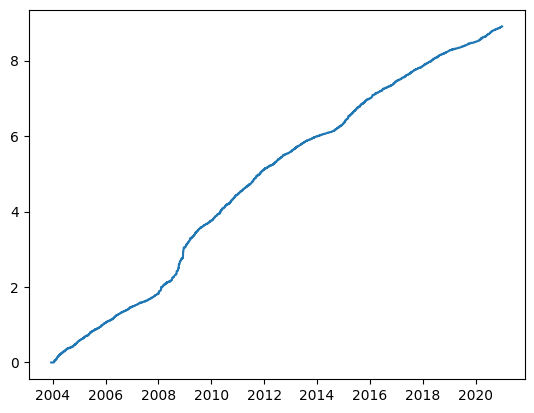

In [56]:
evaluate_clustering(benchmark_df['labels'], [1], [-1])

In [9]:
from scipy.stats import norm, skewnorm

hmm_df = benchmark_df.copy()
hmm_df['returns'] = np.log1p(hmm_df['returns'])

up_dist = skewnorm.fit(hmm_df[hmm_df["labels"] == +1]["returns"])
neutral_dist = norm.fit(hmm_df[hmm_df["labels"] == 0]["returns"])
dn_dist = skewnorm.fit(hmm_df[hmm_df["labels"] == -1]["returns"])

up_dist, neutral_dist, dn_dist

((3.955070979667683, -0.003611129202434397, 0.009318519460033788),
 (0.00014525985559335882, 0.00852987226548376),
 (-2.8799888084345735, 0.003296709916669833, 0.009084628614634532))

## METHOD 1 : DIRECTLY CLUSTER WINDOWS OF RETURNS

In [10]:
from sklearn.cluster import HDBSCAN, KMeans

In [11]:
direct_kmeans = KMeans(n_clusters=3,
                       random_state=14)

direct_hdb = HDBSCAN()

direct_kmeans.fit(data_windows), direct_hdb.fit(data_windows)

(KMeans(n_clusters=3, random_state=14), HDBSCAN())

In [12]:
labels_kmean = direct_kmeans.labels_
labels_hdb = direct_hdb.labels_

In [13]:
visualize_clustering(labels_hdb)

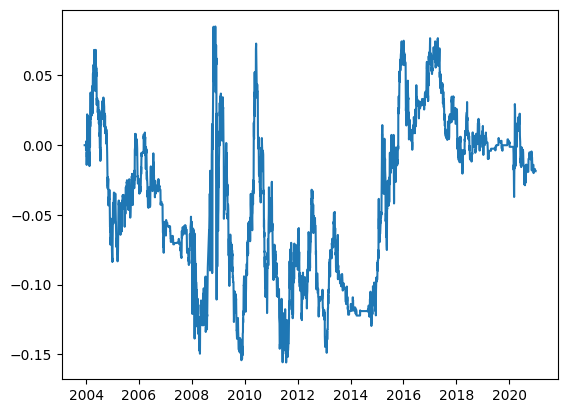

In [14]:
evaluate_clustering(labels_hdb, [1], [-1])

### CONCLUSIONS : 
- KMeans clustering doesn't provide any meaningful clutering. We might use this for permutation entropy computation later on...
- HDBSCan offers better clustering, compared to KMeans
- None of these beat the Two-Moving Average Benchmark (visually)

## METHOD 2 : TR8DR'S AMPLITUDELABELLER

In [27]:
from tseries_patterns import AmplitudeBasedLabeler

In [50]:
labeler = AmplitudeBasedLabeler(20, 3)
labels = labeler.label(train_df)

labels['label']

0       1.0
1       1.0
2       1.0
3       1.0
4       0.0
       ... 
4257    1.0
4258    1.0
4259    1.0
4260    1.0
4261    1.0
Name: label, Length: 4262, dtype: float64

In [51]:
labels['label'].value_counts()

label
 1.0    1719
-1.0    1658
 0.0     885
Name: count, dtype: int64

In [52]:
visualize_clustering(np.array(labels['label']).astype(np.int64))

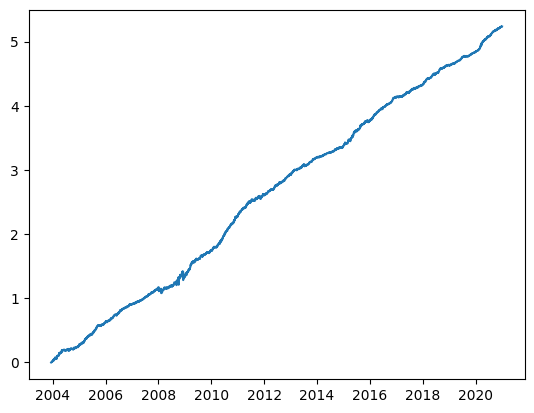

In [58]:

def evaluate_clusterings(labels, labels_long:list, labels_short:list):
    df = train_data.copy()
    df['labels'] = 0

    # Assuming that 'window_size' is an integer count of rows to skip
    start_time = df.index[0] if len(labels) == len(df) else df.index[window_size]
    df.loc[start_time:, 'labels'] = labels

    signals = np.where(np.isin(df['labels'], labels_long), 1,
                       np.where(np.isin(df['labels'], labels_short), -1, 0))
    
    rets = signals * df['returns']

    plt.plot(np.cumsum(rets))
    plt.show()

evaluate_clusterings(labels=np.array(labels['label']).astype(np.int64), labels_long=[1], labels_short=[-1])
